<a href="https://colab.research.google.com/github/atuchiya/openmpw-transistor-level-examples/blob/main/jupyter-notebook/MOSFET/gf180mcu_03v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Install dependencies {display-mode: "form"}
#@markdown - Click the ▷ button to setup the digital design environment based on [conda-eda](https://github.com/hdl/conda-eda).

ngspice_version = 'latest' #@param {type:"string"}
gf180mcu_fd_pr_version = 'latest' #@param {type:"string"}

if ngspice_version == 'latest':
  ngspice_version = ''

if gf180mcu_fd_pr_version == 'latest':
  gf180mcu_fd_pr_version = 'main'

import os
import pathlib
import urllib.request

!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xj bin/micromamba
conda_prefix_path = pathlib.Path('conda-env')
CONDA_PREFIX = str(conda_prefix_path.resolve())
!bin/micromamba create --yes --prefix $CONDA_PREFIX
!echo 'python ==3.7*' >> {CONDA_PREFIX}/conda-meta/pinned
!CI=0 bin/micromamba install --yes --prefix $CONDA_PREFIX \
                     --channel litex-hub \
                     --channel main \
                     ngspice={ngspice_version}

ngspice_models_dir = pathlib.Path('globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice')
ngspice_models_dir.mkdir(exist_ok=True, parents=True)
models = ['design.ngspice', 'sm141064.ngspice', 'sm141064_mim.ngspice', 'smbb000149.ngspice']
for m in models:
  url = f'https://github.com/efabless/globalfoundries-pdk-libs-gf180mcu_fd_pr/raw/{gf180mcu_fd_pr_version}/models/ngspice/{m}'
  print('downloading:', url)
  with urllib.request.urlopen(url) as src:
    with (ngspice_models_dir / m).open('wb') as dst:
      dst.write(src.read())

PATH = os.environ['PATH']
%env CONDA_PREFIX={CONDA_PREFIX}
%env PATH={CONDA_PREFIX}/bin:{PATH}


                                           __
          __  ______ ___  ____ _____ ___  / /_  ____ _
         / / / / __ `__ \/ __ `/ __ `__ \/ __ \/ __ `/
        / /_/ / / / / / / /_/ / / / / / / /_/ / /_/ /
       / .___/_/ /_/ /_/\__,_/_/ /_/ /_/_.___/\__,_/
      /_/

Empty environment created at prefix: /content/conda-env

                                           __
          __  ______ ___  ____ _____ ___  / /_  ____ _
         / / / / __ `__ \/ __ `/ __ `__ \/ __ \/ __ `/
        / /_/ / / / / / / /_/ / / / / / / /_/ / /_/ /
       / .___/_/ /_/ /_/\__,_/_/ /_/ /_/_.___/\__,_/
      /_/


Pinned packages:
  - python 3.7*


Transaction

  Prefix: /content/conda-env

  Updating specs:

   - ngspice=*


  Package                     Version  Build            Channel        Size
─────────────────────────────────────────────────────────────────────────────
  Install:
─────────────────────────────────────────────────────────────────────────────

  + _libgcc_mutex                 0

In [2]:
%%writefile .spiceinit
set ngbehavior=hs

Writing .spiceinit


In [3]:

%%writefile netlist.spice
* PMOS VGS sweep

.include "globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/design.ngspice"
.lib "globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/sm141064.ngspice" typical

.param width=10u
X1 vdp vgp 0 vbp pfet_03v3 w=width l=0.28u AD={width*0.24u} AS={width*0.24u} PD={2*(width + 0.24u)} PS={2*(width + 0.24u)}
vsdp     0  vdp        dc 0.9
vsgp     0  vgp        dc 0.9
vsbp     0  vbp        dc 0
.op
.option post nomod
.end

.control
save all @m.x1.m0[id] @m.x1.m0[gm]  @m.x1.m0[cgg]
dc vsgp 0 1.8 0.01
display
wrdata output.txt @m.x1.m0[id] @m.x1.m0[gm]  @m.x1.m0[cgg]
.endc

Writing netlist.spice


In [4]:


!ngspice -b netlist.spice
     



Note: Compatibility modes selected: hs



Circuit: * pmos vgs sweep

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


No. of Data Rows : 181
Here are the vectors currently active:

Title: * pmos vgs sweep
Name: dc1 (DC transfer characteristic)
Date: Wed May 17 08:13:27  2023

    @m.x1.m0[cgg]       : capacitance, real, 181 long
    @m.x1.m0[gm]        : admittance, real, 181 long
    @m.x1.m0[id]        : current, real, 181 long
    v-sweep             : voltage, real, 181 long [default scale]
    vbp                 : voltage, real, 181 long
    vdp                 : voltage, real, 181 long
    vgp                 : voltage, real, 181 long
    vsbp#branch         : current, real, 181 long
    vsdp#branch         : current, real, 181 long
    vsgp#branch         : current, real, 181 long
Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


No. of Data Rows : 1
	Node                                  Voltage
	----                                  -------
	----	-------
	vb

In [5]:


import math
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("output.txt", delim_whitespace=True, header=None)
df.columns = ["vsg", "gm", "vsg1", "id", "vsg2", "cgg"]
df['gm_id'] = df['gm']/df['id']
df['f_T'] = df['gm']/df['cgg']/2/math.pi
df
     


,vsg,gm,vsg1,id,vsg2,cgg,gm_id,f_T
0,0.00,2.327947e-14,0.00,6.266460e-13,0.00,5.090079e-15,0.037149,7.278949e-01
1,0.01,3.047037e-14,0.01,8.202064e-13,0.01,5.067127e-15,0.037150,9.570531e-01
2,0.02,3.988240e-14,0.02,1.073551e-12,0.02,5.044596e-15,0.037150,1.258273e+00
3,0.03,5.220157e-14,0.03,1.405141e-12,0.03,5.022486e-15,0.037150,1.654188e+00
4,0.04,6.832577e-14,0.04,1.839142e-12,0.04,5.000804e-15,0.037151,2.174527e+00
...,...,...,...,...,...,...,...,...
176,1.76,5.645906e-04,1.76,8.077414e-04,1.76,9.709857e-15,0.698974,9.254244e+09
177,1.77,5.726699e-04,1.77,8.080913e-04,1.77,9.714894e-15,0.708670,9.381806e+09
178,1.78,5.807518e-04,1.78,8.082642e-04,1.78,9.720098e-15,0.718517,9.509114e+09
179,1.79,5.888346e-04,1.79,8.082598e-04,1.79,9.725480e-15,0.728521,9.636124e+09


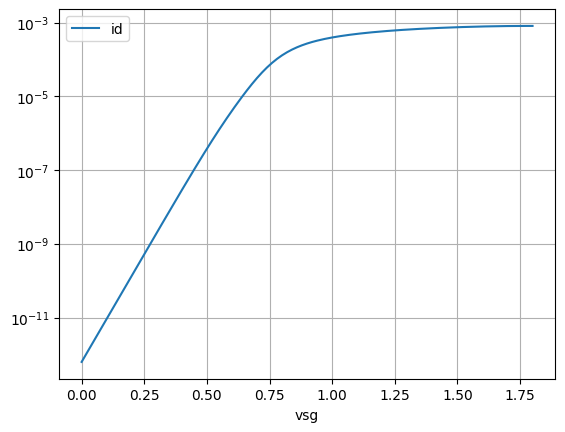

In [6]:

df.plot(x="vsg", y="id", logy=True, grid=True)
plt.show()